In [1]:
%%time
import s3fs
import zarr

url = "s3://hrrrzarr/sfc/20210601/20210601_00z_anl.zarr"
fs = s3fs.S3FileSystem(anon=True)
store = zarr.open(s3fs.S3Map(url, s3=fs))

CPU times: user 630 ms, sys: 89.3 ms, total: 719 ms
Wall time: 838 ms


In [2]:
%%time
thousand_mb_tmp = store["1000mb/TMP/1000mb/TMP"]
surface_tmp = store["surface/TMP/surface/TMP"]
hcdc = store["high_cloud_layer/HCDC/high_cloud_layer/HCDC"]
rh = store["2m_above_ground/RH/2m_above_ground/RH"]
spfh = store["2m_above_ground/SPFH/2m_above_ground/SPFH"]
dpt = store["2m_above_ground/DPT/2m_above_ground/DPT"]
pot = store["2m_above_ground/POT/2m_above_ground/POT"]
tmp = store["2m_above_ground/TMP/2m_above_ground/TMP"]

CPU times: user 25.2 ms, sys: 5.02 ms, total: 30.2 ms
Wall time: 408 ms


In [3]:
%%time
thousand_mb_tmp[...] # load into memory

CPU times: user 116 ms, sys: 18.9 ms, total: 135 ms
Wall time: 662 ms


array([[290.5, 290.5, 290.5, ..., 299.5, 299.5, 299.5],
       [290.5, 290.5, 290.5, ..., 299.5, 299.5, 299.5],
       [290.5, 290.5, 290.5, ..., 299.5, 299.5, 299.5],
       ...,
       [286.5, 286.5, 286.5, ..., 286. , 286. , 285.8],
       [286.5, 286.5, 286.5, ..., 285.8, 285.8, 285.5],
       [286.5, 286.5, 286.5, ..., 285.5, 285.5, 285.5]], dtype=float16)

In [4]:
import xarray as xr
chunk_index = xr.open_zarr(s3fs.S3Map("s3://hrrrzarr/grid/HRRR_chunk_index.zarr", s3=fs))
chunk_index

<xarray.Dataset> Size: 46MB
Dimensions:     (x: 1799, y: 1059)
Coordinates:
  * x           (x) float64 14kB -2.698e+06 -2.695e+06 ... 2.693e+06 2.696e+06
  * y           (y) float64 8kB -1.587e+06 -1.584e+06 ... 1.584e+06 1.587e+06
Data variables:
    chunk_id    (x, y) object 15MB dask.array<chunksize=(225, 265), meta=np.ndarray>
    chunk_x     (x) int32 7kB dask.array<chunksize=(1799,), meta=np.ndarray>
    chunk_y     (y) int32 4kB dask.array<chunksize=(1059,), meta=np.ndarray>
    in_chunk_x  (x) int32 7kB dask.array<chunksize=(1799,), meta=np.ndarray>
    in_chunk_y  (y) int32 4kB dask.array<chunksize=(1059,), meta=np.ndarray>
    index_x     (x) int32 7kB dask.array<chunksize=(1799,), meta=np.ndarray>
    index_y     (y) int32 4kB dask.array<chunksize=(1059,), meta=np.ndarray>
    latitude    (y, x) float64 15MB dask.array<chunksize=(133, 450), meta=np.ndarray>
    longitude   (y, x) float64 15MB dask.array<chunksize=(133, 450), meta=np.ndarray>

/Users/jacksonyip/anaconda3/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


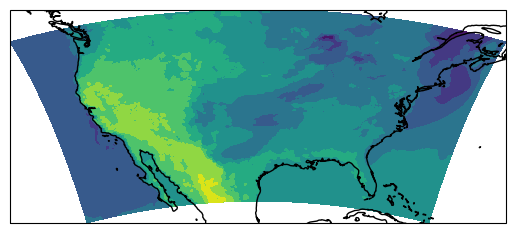

In [5]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

ax = plt.axes(projection=ccrs.PlateCarree())
ax.contourf(chunk_index.longitude, chunk_index.latitude, thousand_mb_tmp)
ax.coastlines()

plt.show()
plt.close()

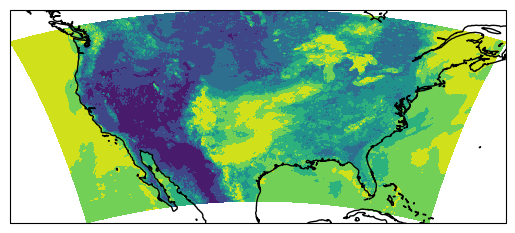

In [6]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.contourf(chunk_index.longitude, chunk_index.latitude, rh)
ax.coastlines()

plt.show()
plt.close()

In [7]:
projection = ccrs.LambertConformal(central_longitude=-97.5,
                             central_latitude=38.5,
                             standard_parallels=[38.5])

def get_nearest_point(projection, chunk_index, longitude, latitude):
    x, y = projection.transform_point(longitude, latitude, ccrs.PlateCarree())
    return chunk_index.sel(x=x, y=y, method="nearest")

nearest_point = get_nearest_point(projection, chunk_index, -111.8910, 40.7608)

first_index = int(nearest_point.index_y.values)
second_index = int(nearest_point.index_x.values)

In [8]:
pot[first_index, second_index]

313.8

In [9]:
url = "s3://hrrrzarr/sfc/20210108/20210108_00z_fcst.zarr"
store = zarr.open(s3fs.S3Map(url, s3=fs))
tmp_forecast = store["surface/TMP/surface/TMP"][:, first_index, second_index]
tmp_forecast

array([273.5, 272.2, 271. , 269. , 267. , 266.5, 266.5, 266.8, 267. ,
       266.2, 266.8, 266. , 265.2, 264.8, 264.5, 267.2, 274. , 278.5,
       282. , 284. , 284.5, 283.8, 281.5, 277.8, 274.5, 273. , 273. ,
       272.8, 272.8, 270.8, 270.2, 268.2, 269.5, 268.8, 269.5, 270. ,
       270.5, 271.2, 271.8, 272.5, 273. , 273.2, 273.5, 277.2, 277.8,
       277.2, 276.8, 274.2], dtype=float16)

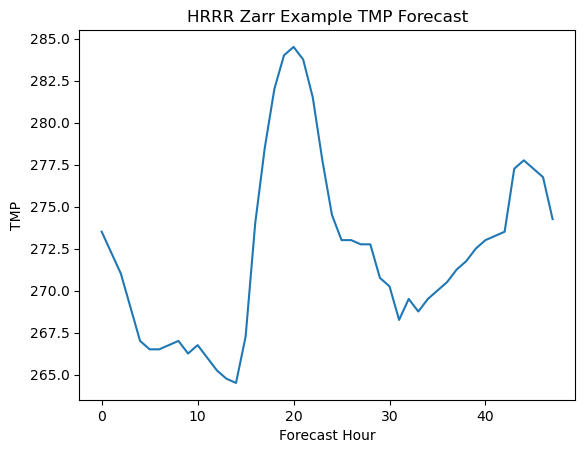

In [10]:
plt.title('HRRR Zarr Example TMP Forecast')
plt.xlabel('Forecast Hour')
plt.ylabel("TMP")
plt.plot(tmp_forecast)
plt.show()
plt.close()

In [11]:
%%time
import datetime

start = datetime.datetime.strptime("20210108_00", '%Y%m%d_%H')
forecast_length = len(tmp_forecast)
tmp_analysis = []

for time_delta in range(forecast_length):
    # construct the aws path
    analysis_time = start + datetime.timedelta(hours=time_delta)
    string_date = analysis_time.strftime('%Y%m%d')
    string_hour   = analysis_time.strftime('%H')
    url = 's3://hrrrzarr/sfc/%s/%s_%sz_anl.zarr' %(string_date, string_date, string_hour)
    
    # open the zarr group
    store = zarr.open(s3fs.S3Map(url, s3=fs))
    
    # append the data we need
    tmp_analysis.append(store["surface/TMP/surface/TMP"][first_index, second_index])

CPU times: user 1.51 s, sys: 259 ms, total: 1.77 s
Wall time: 14.7 s


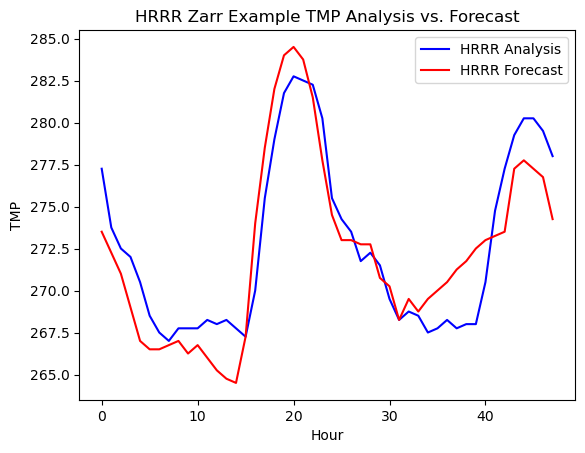

In [12]:
plt.title('HRRR Zarr Example TMP Analysis vs. Forecast')
plt.xlabel('Hour')
plt.ylabel("TMP")
plt.plot(tmp_analysis, color='blue', label='HRRR Analysis')
plt.plot(tmp_forecast, color='red', label='HRRR Forecast')
plt.legend()
plt.show()
plt.close()